## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'batch0approx1e5-agriVision-wavelet-gray' # size-name-transform-channel

In [2]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
RERUN = True
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/agriVision/wavelet/batch0approx1e5/gray'

In [3]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [4]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if path_dict['transform'] == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
else:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 9000,
 3: 36000,
 4: 144000,
 5: 576000,
 6: 2304000,
 7: 9216000,
 8: 36864000,
 9: 147456000,
 10: 589824000}

In [5]:
''' Only need to run commented code once'''
all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
all_cdfs_df.head()

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:818: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:823: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:823: RuntimeWarning: overflow encountered in scalar power
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:823: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2


,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.02, -1.4), <scipy.interpolate._fitpack2.In...",0.02,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,9.618487e+69,1.391529e+25
1,"((0.02, -1.3), <scipy.interpolate._fitpack2.In...",0.02,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.821735e+74,8.172634e+21
2,"((0.02, -1.2), <scipy.interpolate._fitpack2.In...",0.02,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.455488e+78,4.131785e+19
3,"((0.02, -1.1), <scipy.interpolate._fitpack2.In...",0.02,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.406735e+81,6.947275e+17
4,"((0.02, -1.0), <scipy.interpolate._fitpack2.In...",0.02,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.331443e+83,2.562075e+16


## Bootstrapping the Variance and Kurtosis

In [6]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [7]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:52<00:00, 1916.96it/s]


Layer 3


100%|██████████| 100000/100000 [00:54<00:00, 1833.94it/s]


Layer 4


100%|██████████| 100000/100000 [00:46<00:00, 2170.13it/s]


Layer 5


100%|██████████| 100000/100000 [00:45<00:00, 2180.61it/s]


Layer 6


100%|██████████| 100000/100000 [00:46<00:00, 2155.61it/s]


Layer 7


100%|██████████| 100000/100000 [00:45<00:00, 2179.82it/s]


Layer 8


100%|██████████| 100000/100000 [00:46<00:00, 2170.53it/s]


Layer 9


100%|██████████| 100000/100000 [00:45<00:00, 2178.22it/s]


Layer 10


100%|██████████| 100000/100000 [00:46<00:00, 2162.46it/s]


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,150199.610000,85008.824102,248364.732266,411.567795,85.166882,581.245881,9000.0
3,33515.562000,19958.825879,52689.479258,366.283332,101.325688,561.984535,36000.0
4,8690.716000,4650.655151,15441.937554,584.811266,124.448718,1337.453648,144000.0
5,1600.961900,772.053137,3722.834314,1309.721219,95.400870,3193.442929,576000.0
6,339.519200,152.123086,1059.839684,2687.210297,93.111475,4763.505439,2304000.0
7,87.086320,35.836773,371.805410,4823.475991,72.400958,6356.322824,9216000.0
8,29.883560,15.550574,79.512060,1685.915861,80.564132,3720.926795,36864000.0
9,8.940126,4.773328,23.294833,1591.253639,83.608903,3578.031731,147456000.0
10,1.353995,0.687269,4.314199,2561.703720,78.230434,4657.250795,589824000.0


## Initial Grid Search and Hypothesis Test Plots

####
Layer  2


100%|██████████| 52429/52429 [00:18<00:00, 2810.56it/s]


Finding Minimum after computing 52429 CDFs
Number of samples: 9000, Without approximation : 9000.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


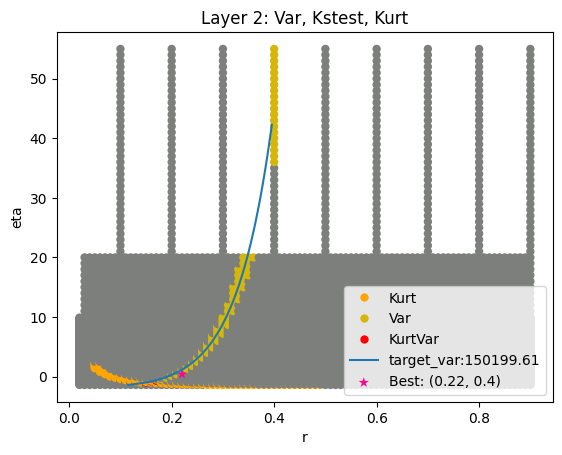

####
Layer  3


100%|██████████| 52429/52429 [01:05<00:00, 801.13it/s]


Finding Minimum after computing 52429 CDFs
Number of samples: 36000, Without approximation : 36000.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


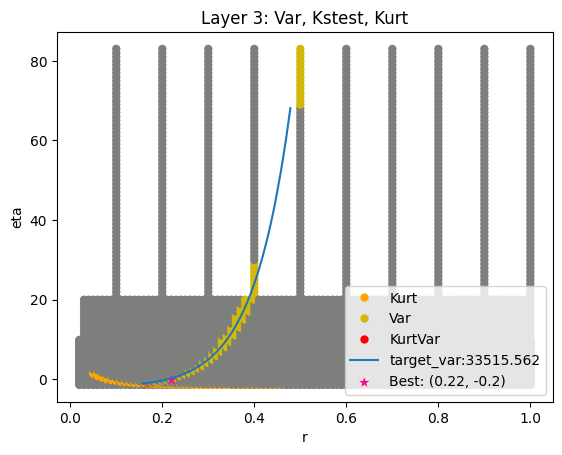

####
Layer  4


100%|██████████| 52429/52429 [02:53<00:00, 302.98it/s]


Finding Minimum after computing 52429 CDFs
Number of samples: 100000, Without approximation : 144000.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


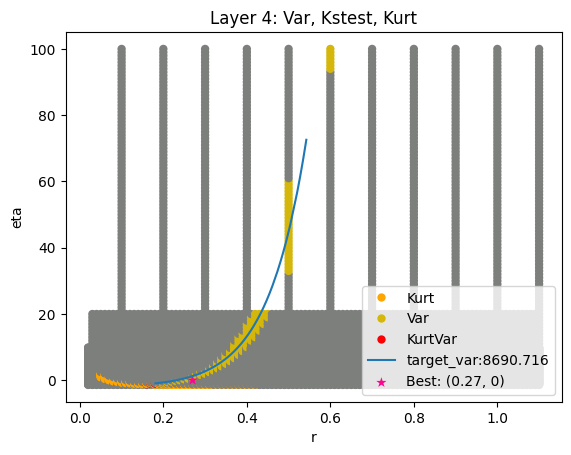

####
Layer  5


100%|██████████| 52429/52429 [02:52<00:00, 303.14it/s]


Finding Minimum after computing 52429 CDFs
Number of samples: 100000, Without approximation : 576000.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


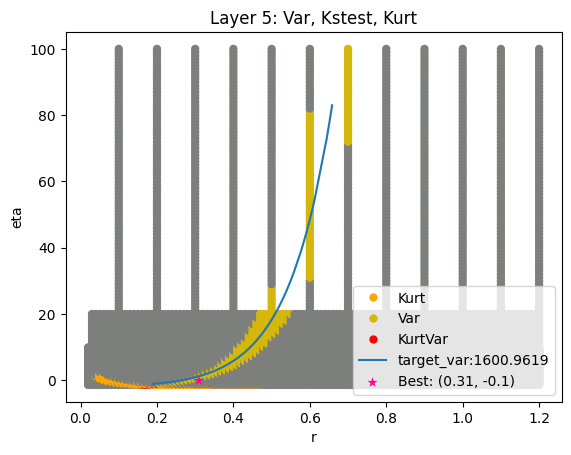

####
Layer  6


100%|██████████| 52429/52429 [02:52<00:00, 303.86it/s]


Finding Minimum after computing 52429 CDFs
Number of samples: 100000, Without approximation : 2304000.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


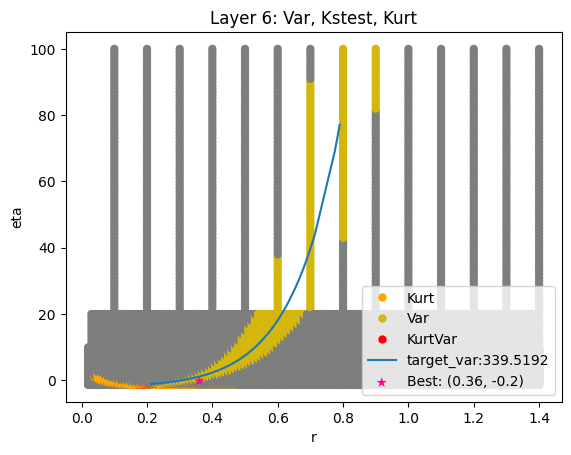

####
Layer  7


100%|██████████| 52429/52429 [02:52<00:00, 304.25it/s]


Finding Minimum after computing 52429 CDFs
Number of samples: 100000, Without approximation : 9216000.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


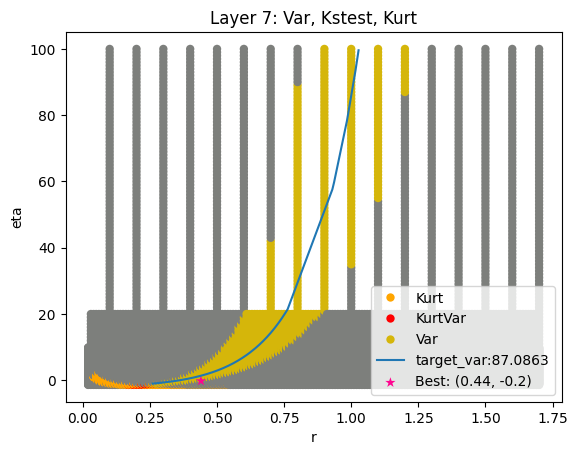

####
Layer  8


100%|██████████| 52429/52429 [02:53<00:00, 302.52it/s]


Finding Minimum after computing 52429 CDFs
Number of samples: 100000, Without approximation : 36864000.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


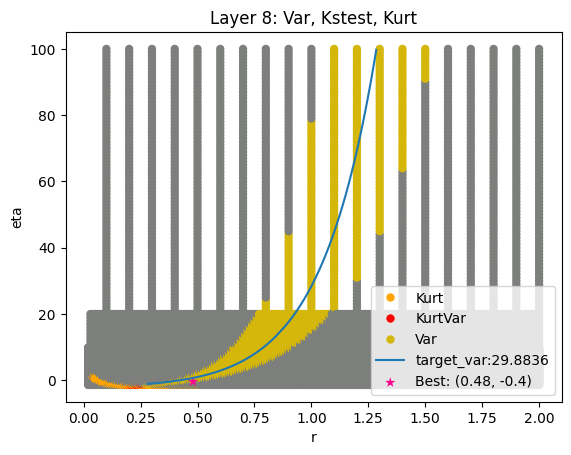

####
Layer  9


100%|██████████| 52429/52429 [02:52<00:00, 304.35it/s]


Finding Minimum after computing 52429 CDFs
Number of samples: 100000, Without approximation : 147456000.0


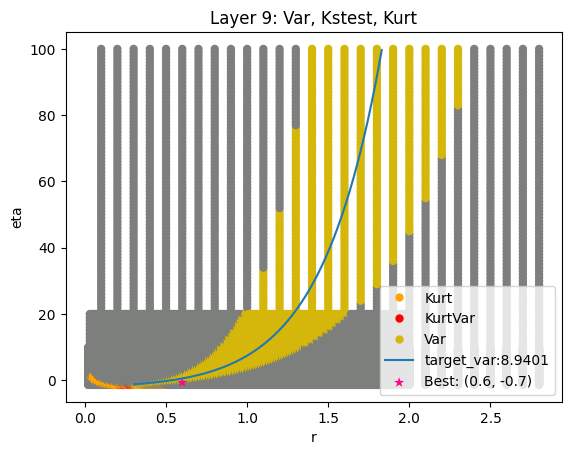

####
Layer  10


100%|██████████| 52429/52429 [02:52<00:00, 303.61it/s]


Finding Minimum after computing 52429 CDFs
Number of samples: 100000, Without approximation : 589824000.0


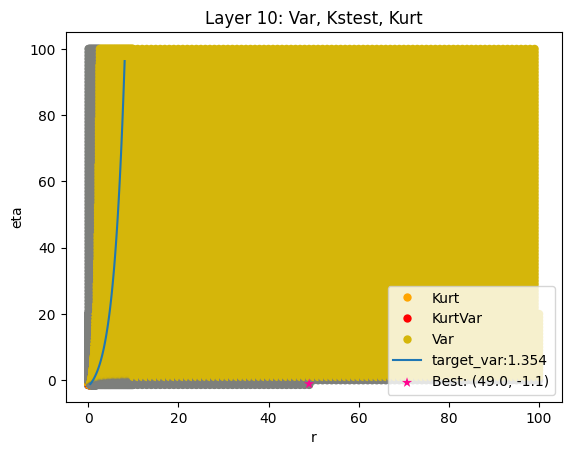

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,
2,150199.610000,85008.824102,248364.732266,411.567795,85.166882,581.245881,9000.0,0.22,0.4,0.017328,0.014297
3,33515.562000,19958.825879,52689.479258,366.283332,101.325688,561.984535,36000.0,0.22,-0.2,0.015524,0.007153
4,8690.716000,4650.655151,15441.937554,584.811266,124.448718,1337.453648,144000.0,0.27,0.0,0.014394,0.003578
5,1600.961900,772.053137,3722.834314,1309.721219,95.400870,3193.442929,576000.0,0.31,-0.1,0.012362,0.001789
6,339.519200,152.123086,1059.839684,2687.210297,93.111475,4763.505439,2304000.0,0.36,-0.2,0.007668,0.000895
7,87.086320,35.836773,371.805410,4823.475991,72.400958,6356.322824,9216000.0,0.44,-0.2,0.006620,0.000447
8,29.883560,15.550574,79.512060,1685.915861,80.564132,3720.926795,36864000.0,0.48,-0.4,0.006882,0.000224
9,8.940126,4.773328,23.294833,1591.253639,83.608903,3578.031731,147456000.0,0.60,-0.7,0.008517,0.000112
10,1.353995,0.687269,4.314199,2561.703720,78.230434,4657.250795,589824000.0,49.00,-1.1,0.027959,0.000056


In [8]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True)
        master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        master_df.loc[group, 'kstest_stat_initial'] = min_stat
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = master_df.loc[group, 'obs_var'],
                            best_param = initial_param)
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)

        # Optional: Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

### Search over $\eta=0$

In [9]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True)
            best_params_eta0.append(best_param_eta0[0])
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            best_params_eta0.append(master_df.loc[group, 'initial_r'])
    master_df['best_r_eta0'] = best_params_eta0
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

100%|██████████| 369/369 [00:00<00:00, 2726.37it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 825.23it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 308.04it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 307.91it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 309.12it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 308.26it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 308.23it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 309.11it/s]

Finding Minimum after computing 369 CDFs


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,best_r_eta0
layer,,,,,,,,,,,,,
2,150199.610000,85008.824102,248364.732266,411.567795,85.166882,581.245881,9000.0,0.22,0.4,0.017328,0.014297,0.030628,0.20
3,33515.562000,19958.825879,52689.479258,366.283332,101.325688,561.984535,36000.0,0.22,-0.2,0.015524,0.007153,0.023693,0.23
4,8690.716000,4650.655151,15441.937554,584.811266,124.448718,1337.453648,144000.0,0.27,0.0,0.014394,0.003578,0.014394,0.27
5,1600.961900,772.053137,3722.834314,1309.721219,95.400870,3193.442929,576000.0,0.31,-0.1,0.012362,0.001789,0.013447,0.32
6,339.519200,152.123086,1059.839684,2687.210297,93.111475,4763.505439,2304000.0,0.36,-0.2,0.007668,0.000895,0.010071,0.38
7,87.086320,35.836773,371.805410,4823.475991,72.400958,6356.322824,9216000.0,0.44,-0.2,0.006620,0.000447,0.008852,0.47
8,29.883560,15.550574,79.512060,1685.915861,80.564132,3720.926795,36864000.0,0.48,-0.4,0.006882,0.000224,0.015291,0.58
9,8.940126,4.773328,23.294833,1591.253639,83.608903,3578.031731,147456000.0,0.60,-0.7,0.008517,0.000112,0.026090,1.06
10,1.353995,0.687269,4.314199,2561.703720,78.230434,4657.250795,589824000.0,49.00,-1.1,0.027959,0.000056,0.143098,6.20


## Optimization

In [10]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Layer 2


100%|██████████| 420/420 [00:00<00:00, 2959.64it/s]


Finding Minimum after computing 420 CDFs
Iter 1 layer 2 best parameters: ((0.217, 0.31), 0.013913149988188211)


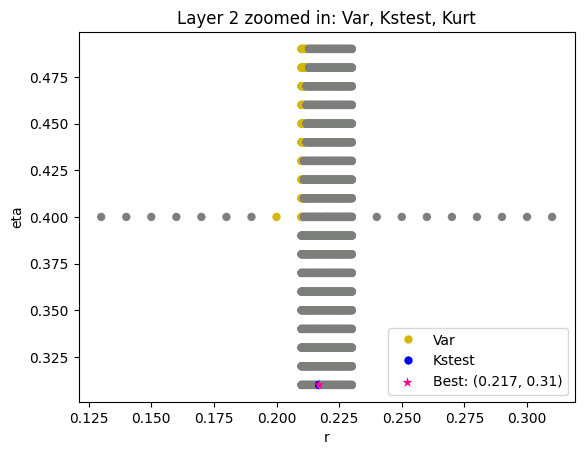

Layer 3


100%|██████████| 441/441 [00:00<00:00, 802.39it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 3 best parameters: ((0.226, -0.11), 0.013650223497866265)


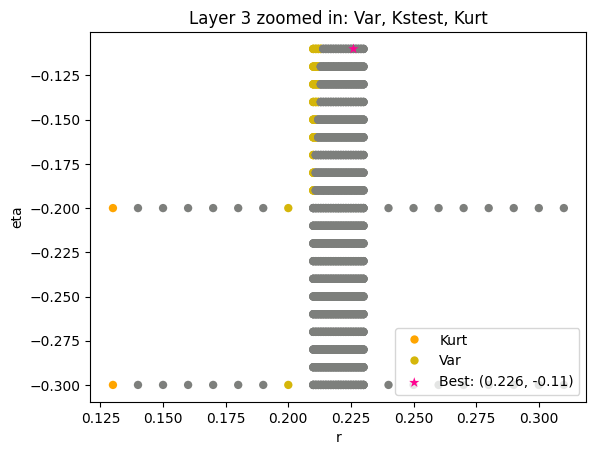

Layer 4


100%|██████████| 441/441 [00:02<00:00, 212.13it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 4 best parameters: ((0.263, -0.1), 0.01271372917426718)


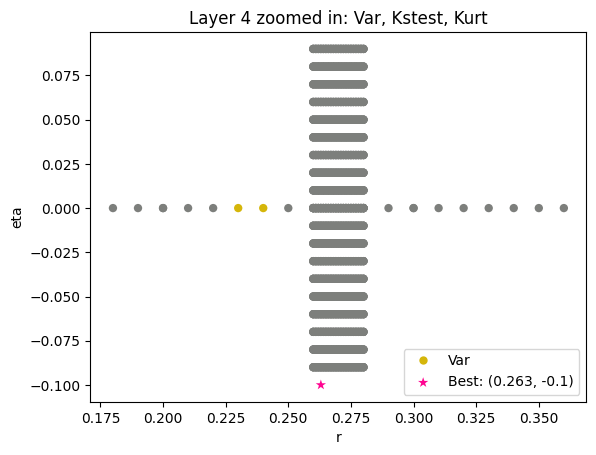

Layer 5


100%|██████████| 420/420 [00:01<00:00, 251.56it/s]


Finding Minimum after computing 420 CDFs
Iter 1 layer 5 best parameters: ((0.302, -0.2), 0.010524860662266766)


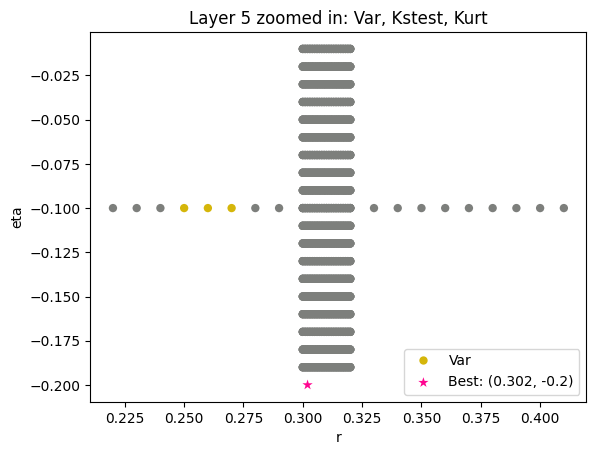

Layer 6


100%|██████████| 441/441 [00:01<00:00, 280.08it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 6 best parameters: ((0.355, -0.23), 0.0069518332997928756)


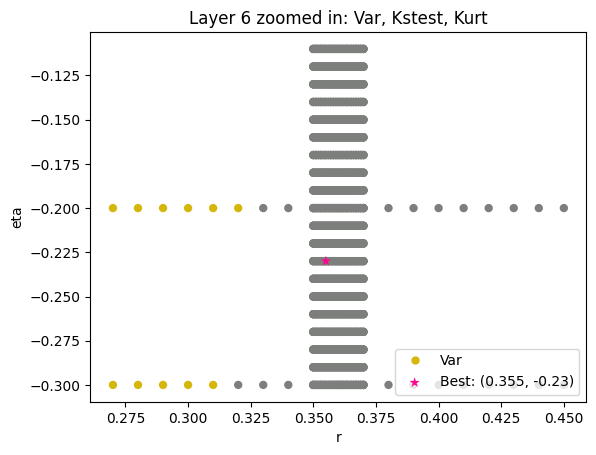

Layer 7


100%|██████████| 441/441 [00:01<00:00, 274.88it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 7 best parameters: ((0.43, -0.23), 0.005400085921761666)


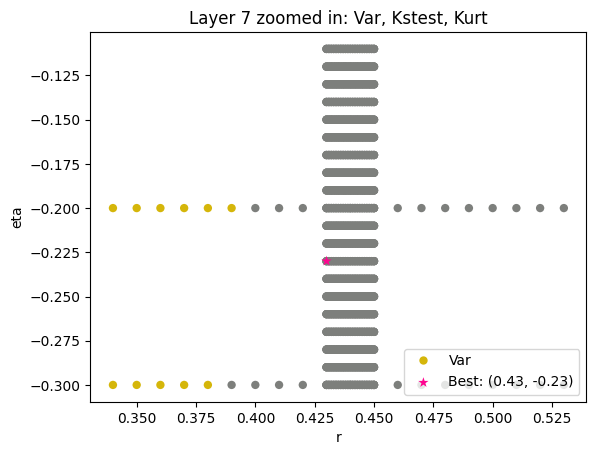

Layer 8


100%|██████████| 420/420 [00:01<00:00, 305.10it/s]


Finding Minimum after computing 420 CDFs
Iter 1 layer 8 best parameters: ((0.47, -0.45), 0.005399417861894795)


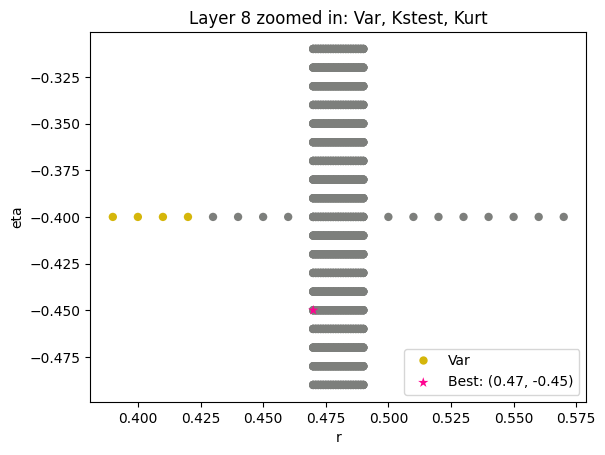

Layer 9


100%|██████████| 420/420 [00:01<00:00, 294.91it/s]
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/plotting.py:38: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  fig = sns.scatterplot(df, x='r', y='eta', hue='map', palette = fixed_palette, ax=ax, alpha=1, edgecolor='none')


Finding Minimum after computing 420 CDFs
Iter 1 layer 9 best parameters: ((0.594, -0.71), 0.008222602246935795)


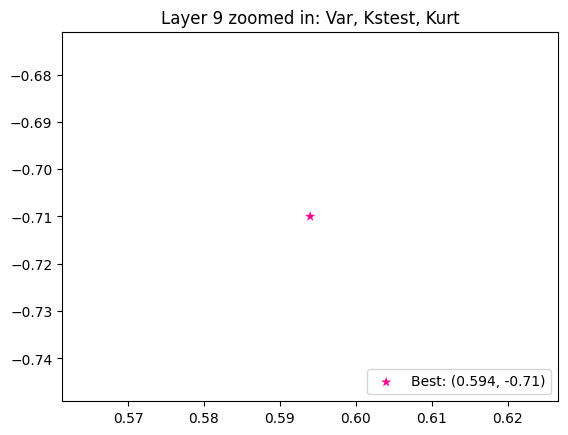

Layer 10


100%|██████████| 462/462 [00:01<00:00, 301.69it/s]
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/plotting.py:38: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  fig = sns.scatterplot(df, x='r', y='eta', hue='map', palette = fixed_palette, ax=ax, alpha=1, edgecolor='none')


Finding Minimum after computing 462 CDFs
Iter 1 layer 10 best parameters: ((9.9999, -1.07), 0.022544635818924796)


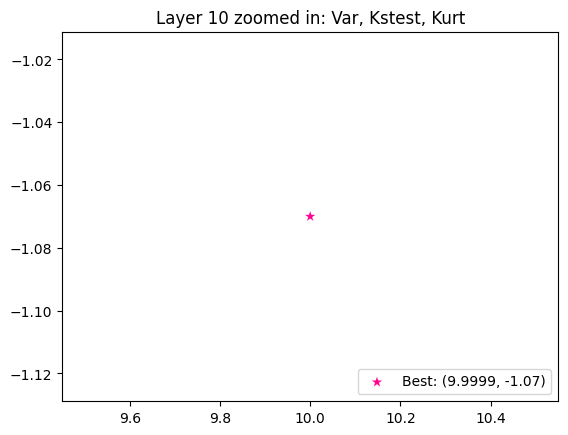

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,150199.610000,85008.824102,248364.732266,411.567795,85.166882,581.245881,9000.0,0.22,0.4,0.017328,...,126.386000,0.053287,1.188320e-22,112.080000,0.027644,2.081510e-06,88.349400,0.024432,4.239170e-05,6.077456e-02
3,33515.562000,19958.825879,52689.479258,366.283332,101.325688,561.984535,36000.0,0.22,-0.2,0.015524,...,51.097400,0.057075,2.235480e-102,45.218000,0.030592,1.054640e-29,35.563000,0.028171,2.979370e-25,2.954783e-06
4,8690.716000,4650.655151,15441.937554,584.811266,124.448718,1337.453648,144000.0,0.27,0.0,0.014394,...,21.927100,0.052141,0.000000e+00,19.615600,0.027260,2.143050e-93,15.331800,0.022689,7.963070e-65,1.200534e-20
5,1600.961900,772.053137,3722.834314,1309.721219,95.400870,3193.442929,576000.0,0.31,-0.1,0.012362,...,10.281000,0.046289,0.000000e+00,9.169130,0.022133,1.499790e-245,7.236210,0.015874,1.665910e-126,7.520722e-56
6,339.519200,152.123086,1059.839684,2687.210297,93.111475,4763.505439,2304000.0,0.36,-0.2,0.007668,...,5.464020,0.038784,0.000000e+00,4.855720,0.015043,0.000000e+00,3.837820,0.009457,2.077520e-179,3.833990e-97
7,87.086320,35.836773,371.805410,4823.475991,72.400958,6356.322824,9216000.0,0.44,-0.2,0.006620,...,3.123040,0.035890,0.000000e+00,2.768430,0.011098,0.000000e+00,2.214910,0.009042,0.000000e+00,7.390790e-234
8,29.883560,15.550574,79.512060,1685.915861,80.564132,3720.926795,36864000.0,0.48,-0.4,0.006882,...,2.034520,0.040489,0.000000e+00,1.797250,0.014289,0.000000e+00,1.433200,0.012347,0.000000e+00,0.000000e+00
9,8.940126,4.773328,23.294833,1591.253639,83.608903,3578.031731,147456000.0,0.60,-0.7,0.008517,...,1.019810,0.043489,0.000000e+00,0.905438,0.018283,0.000000e+00,0.715500,0.014077,0.000000e+00,0.000000e+00
10,1.353995,0.687269,4.314199,2561.703720,78.230434,4657.250795,589824000.0,49.00,-1.1,0.027959,...,0.370727,0.044892,0.000000e+00,0.329689,0.020144,0.000000e+00,0.259616,0.015220,0.000000e+00,0.000000e+00


In [21]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True)

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']))
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

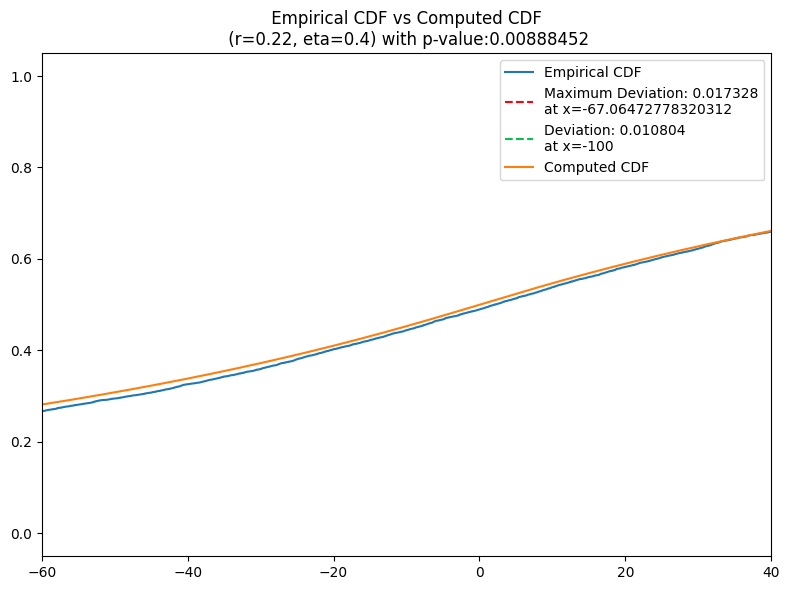

In [12]:
# Example Cell
group = 2
visualize_cdf(sample = group_data_map[group], 
              all_cdfs = None, 
              params = (master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']),
              distro = 'gengamma',
              n_samples=200, 
              interval = (-60, 40), 
              provided_loc = -100);

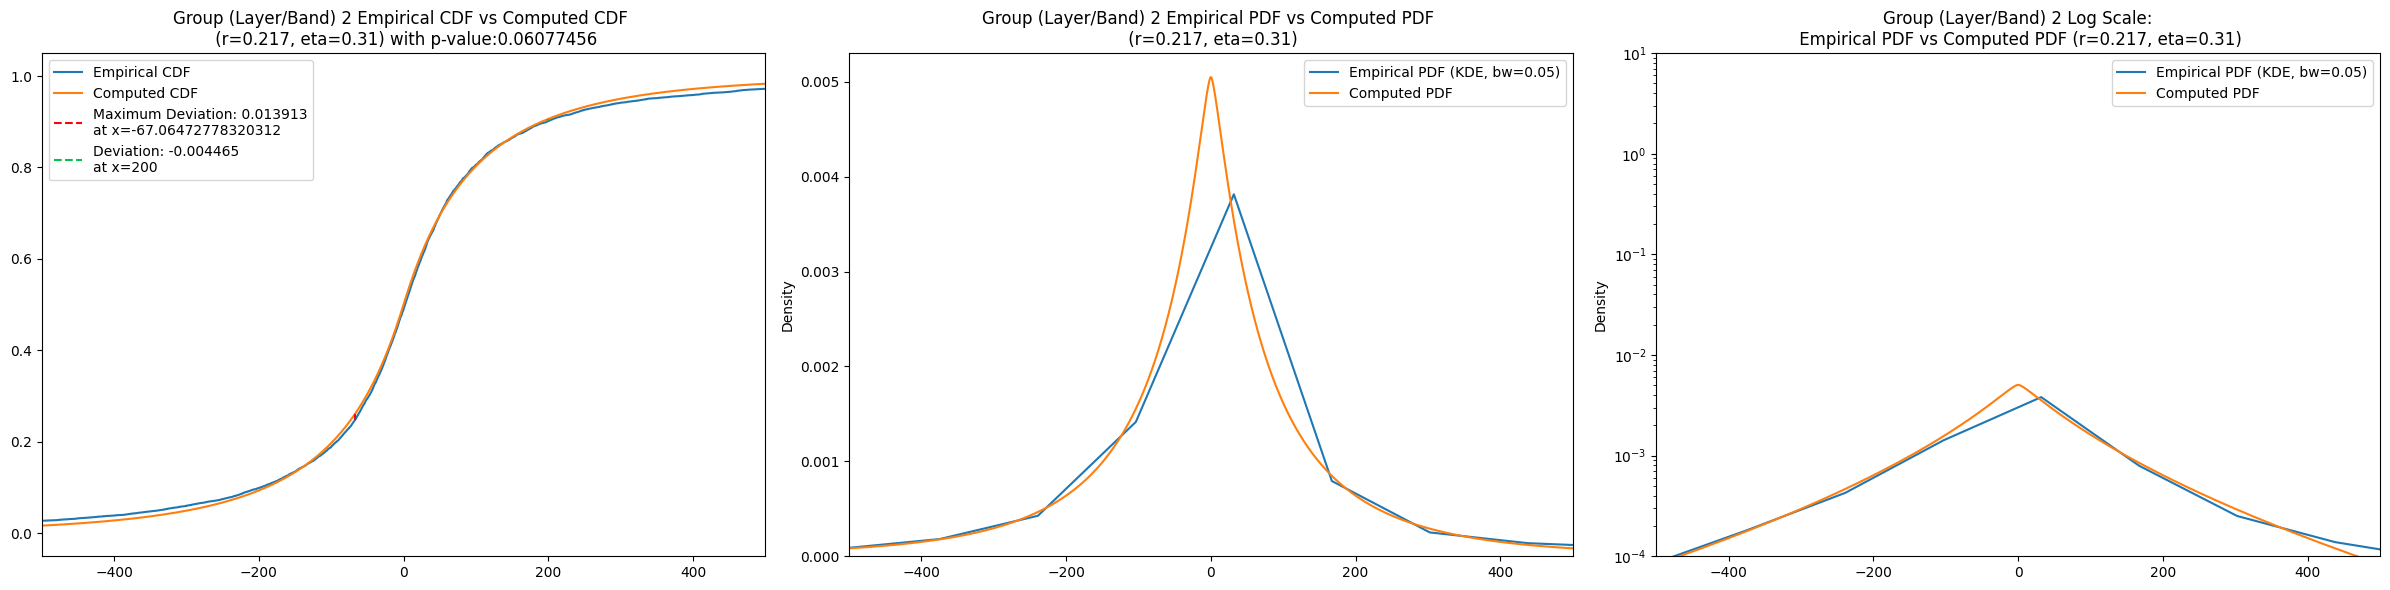

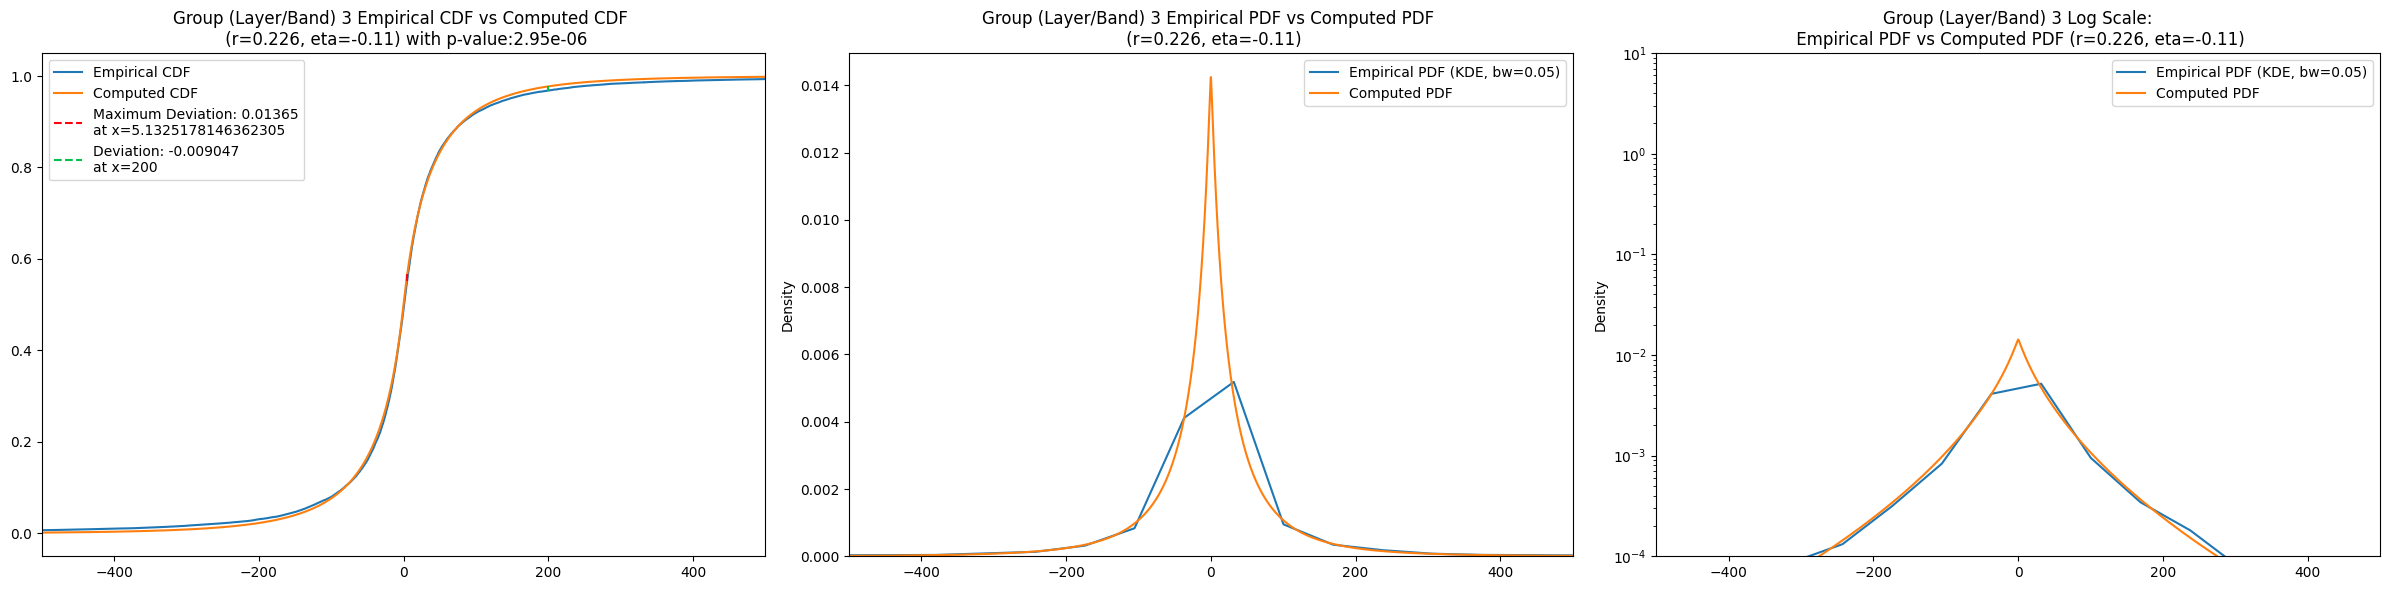

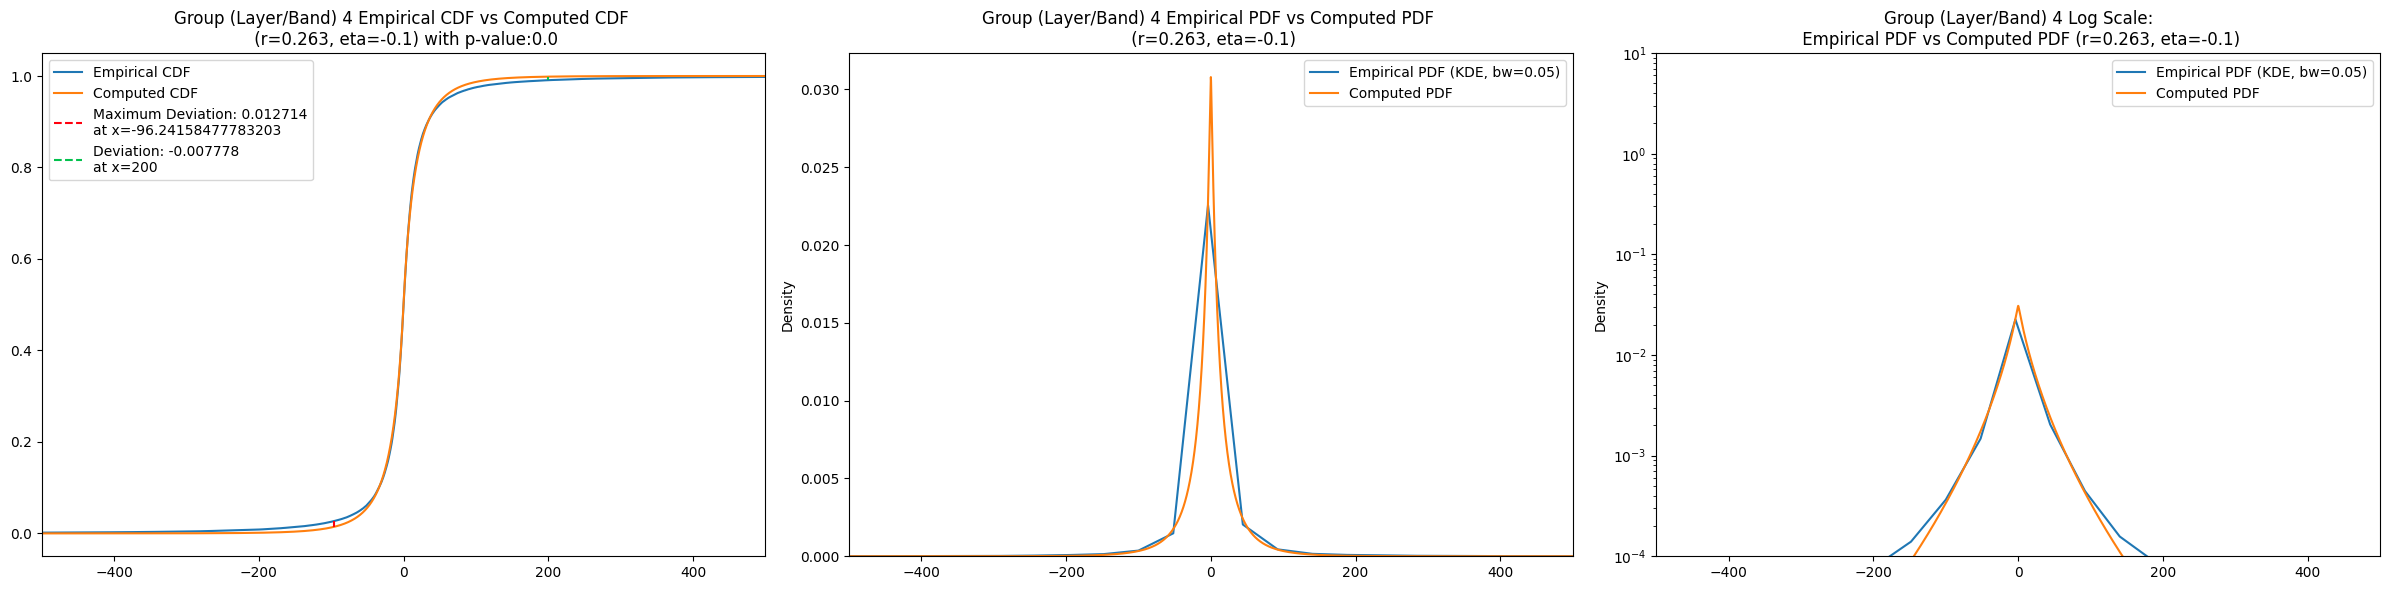

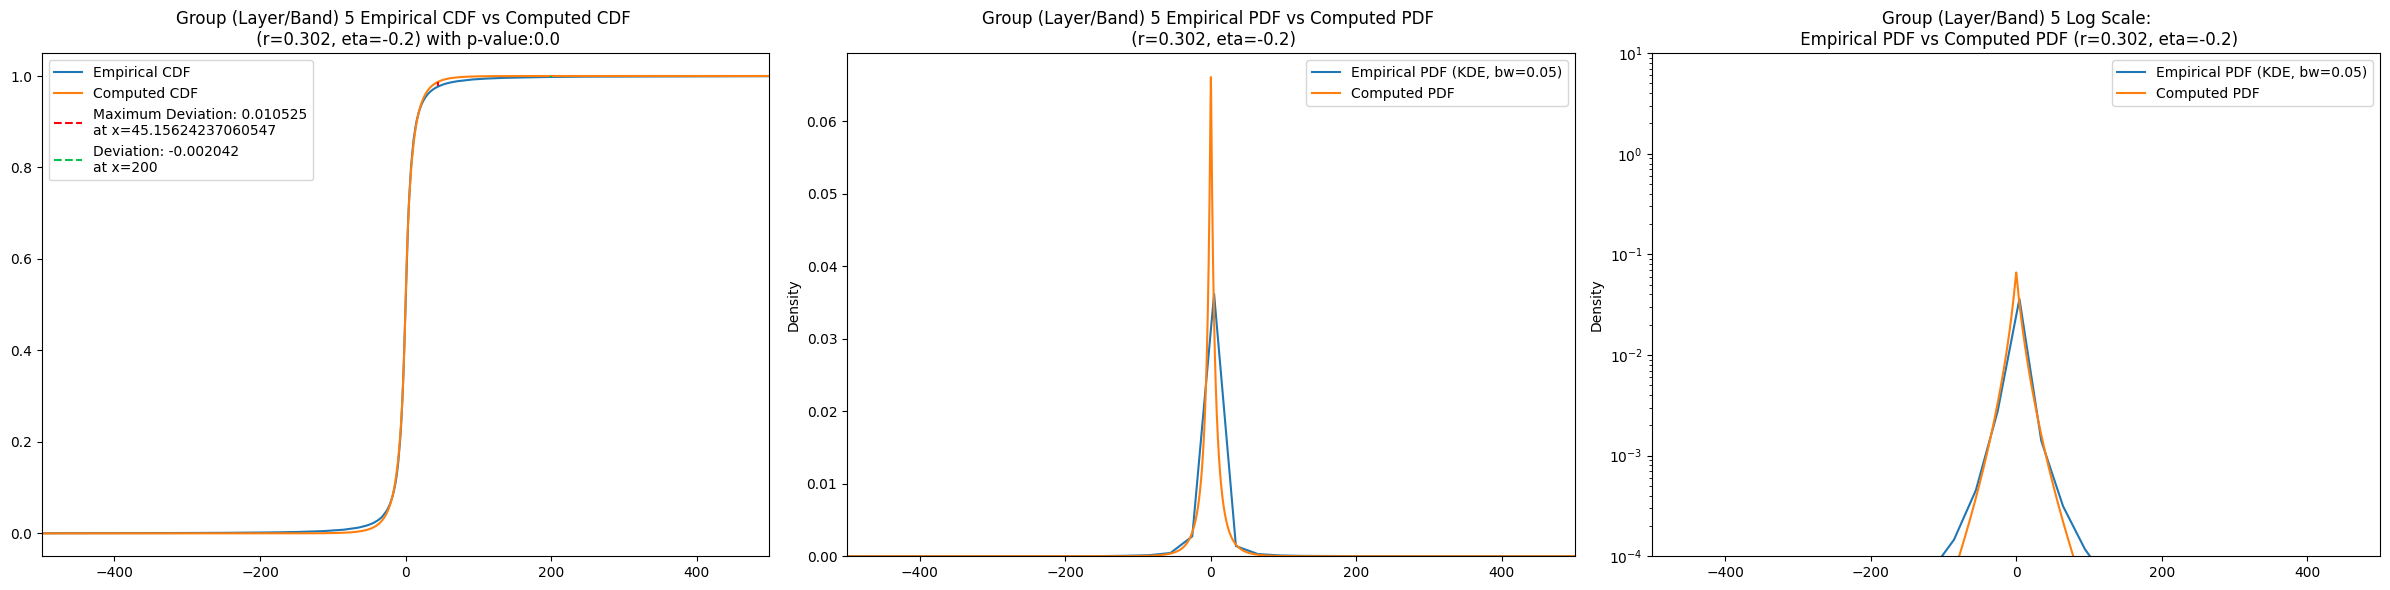

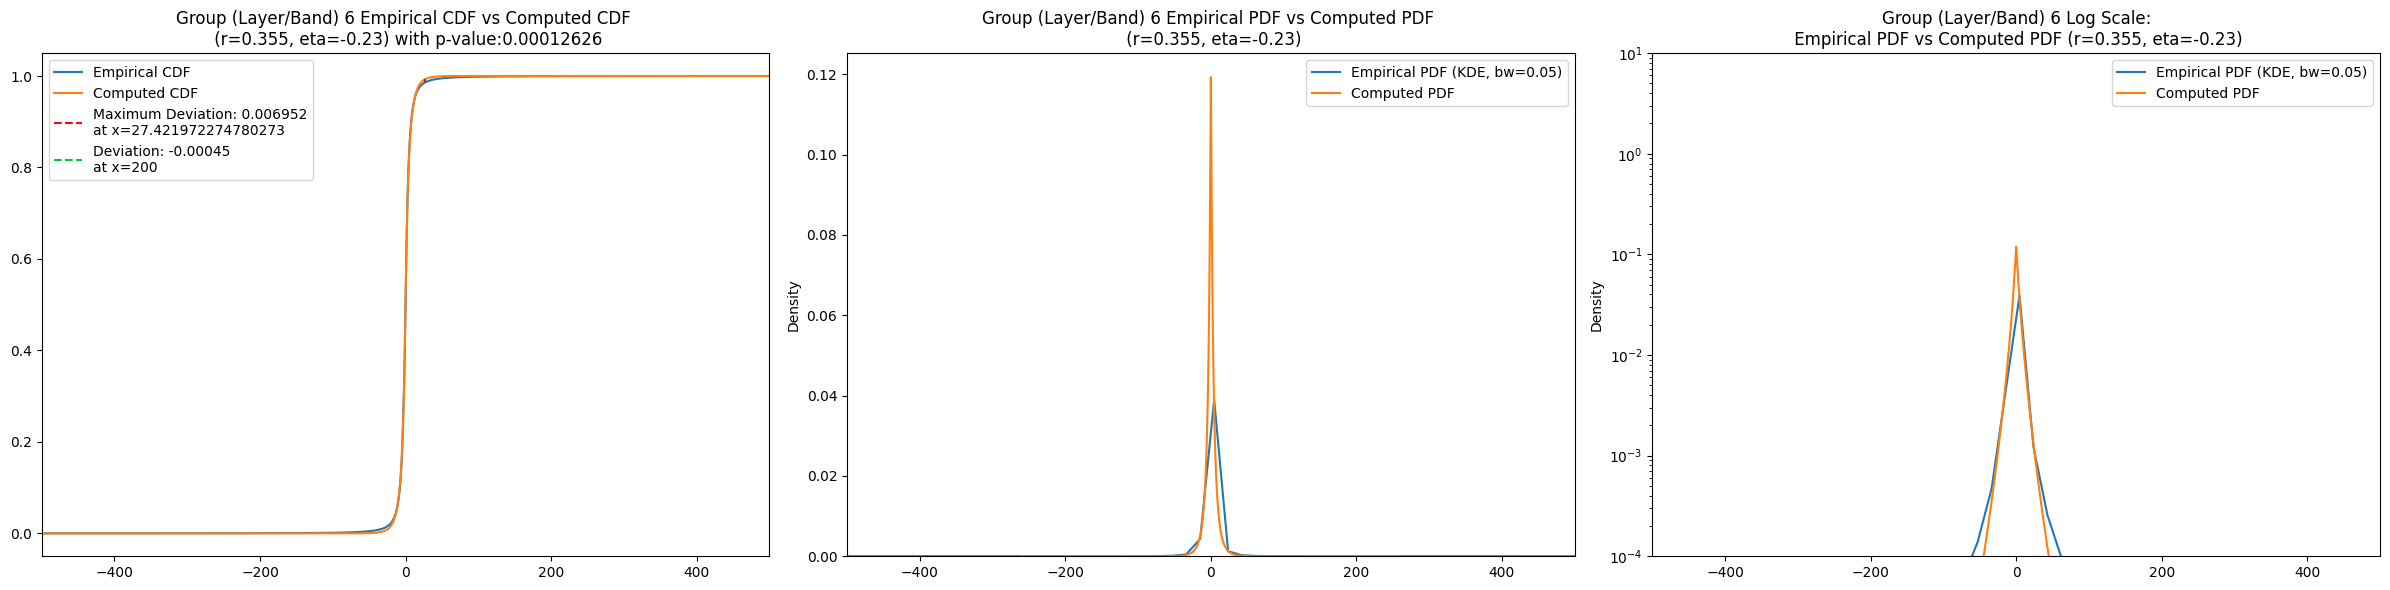

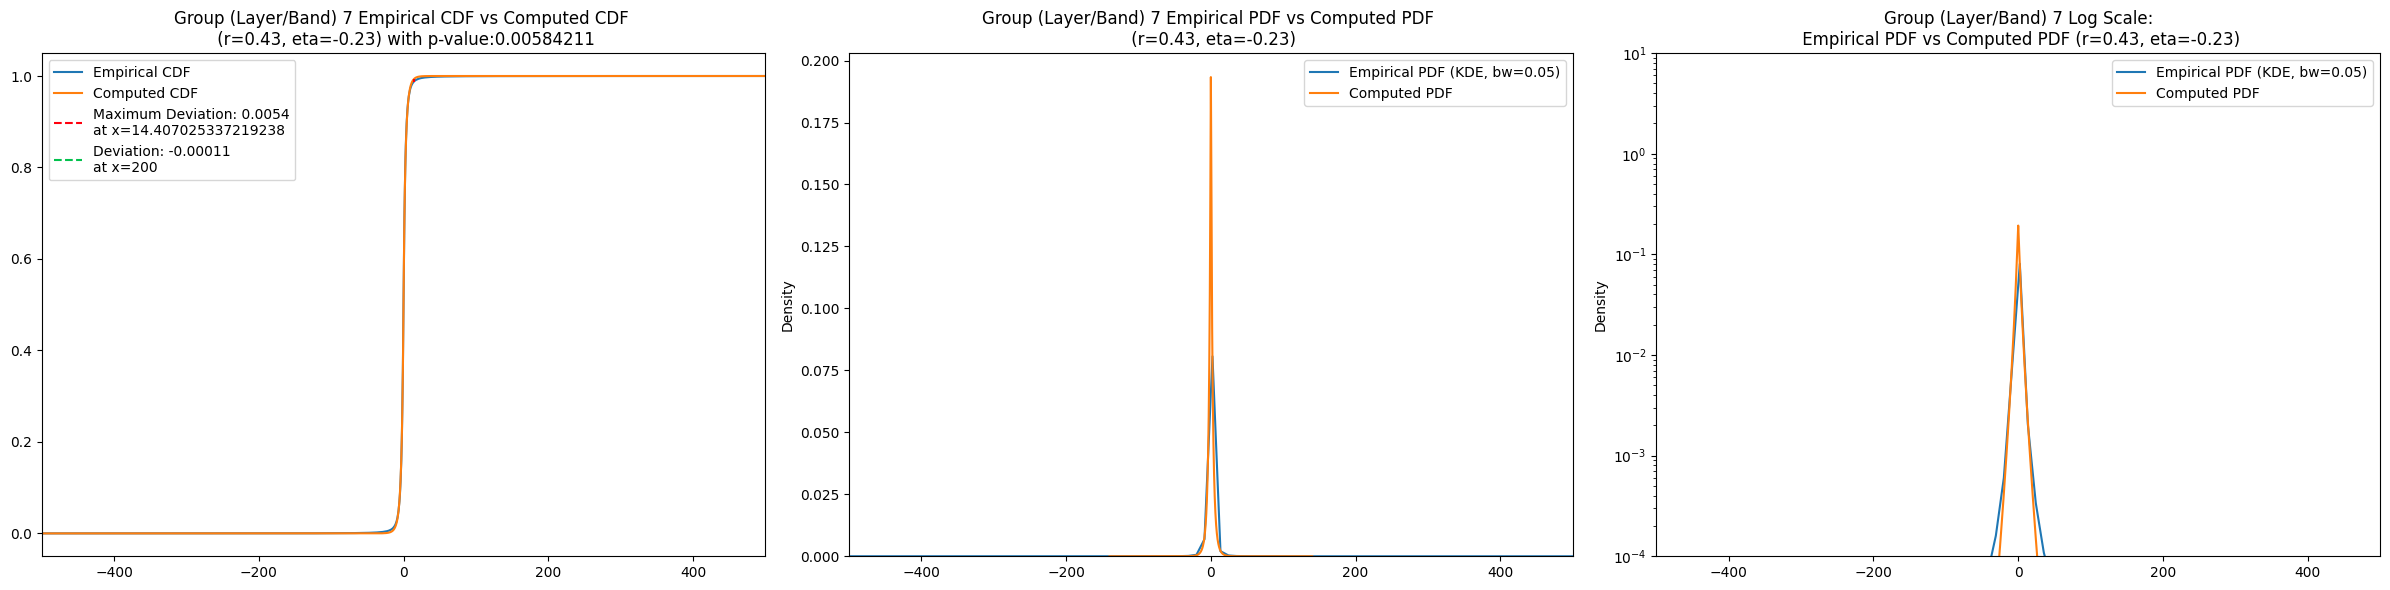

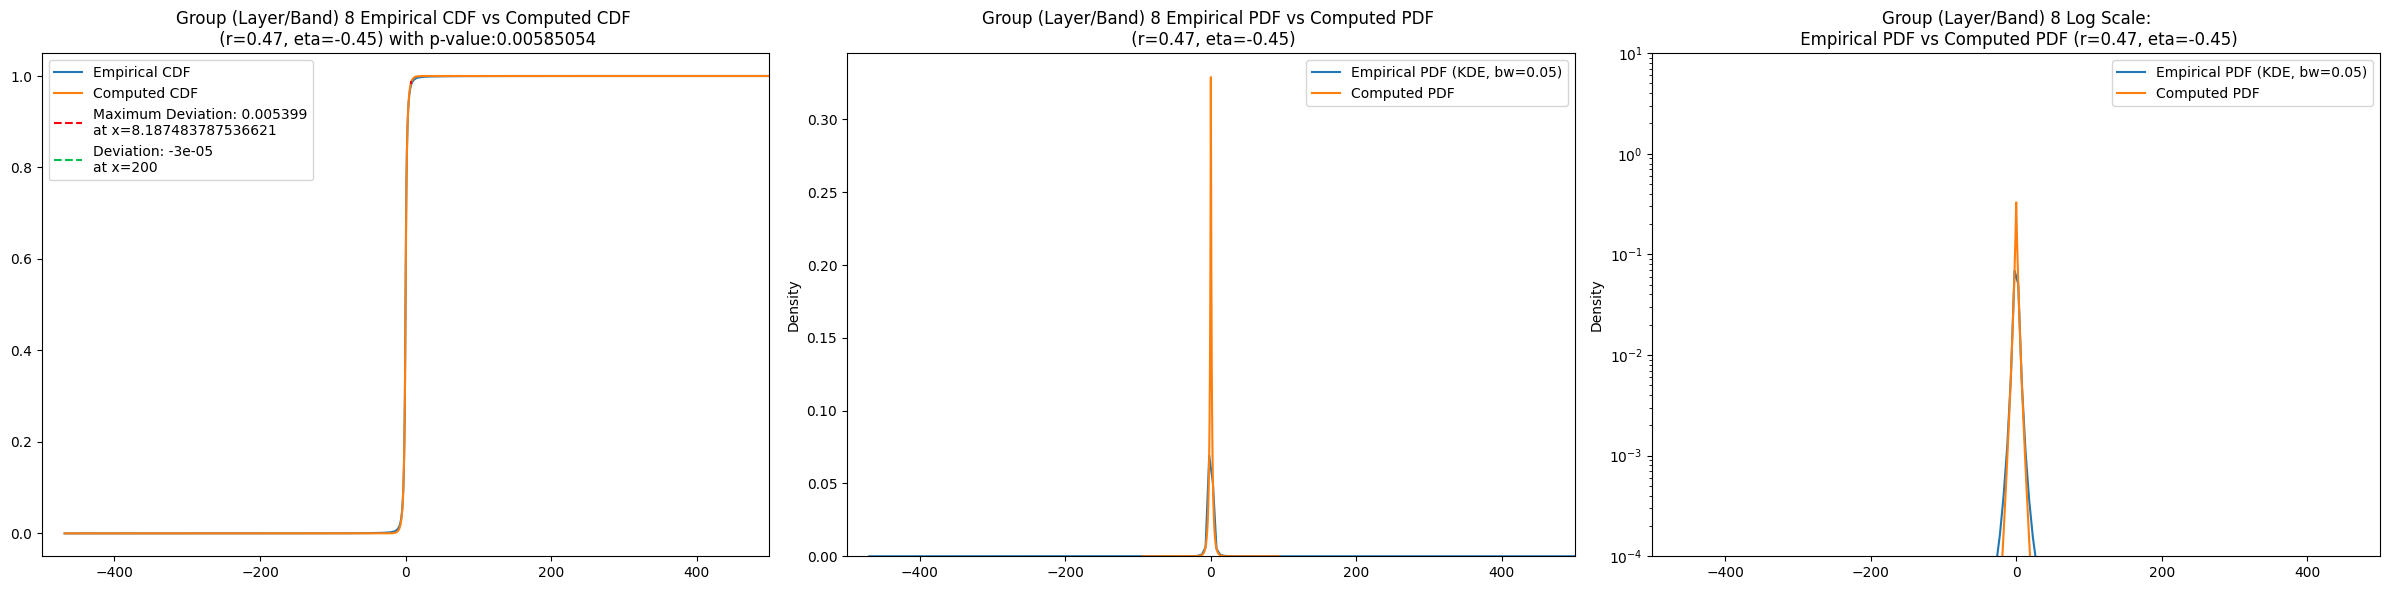

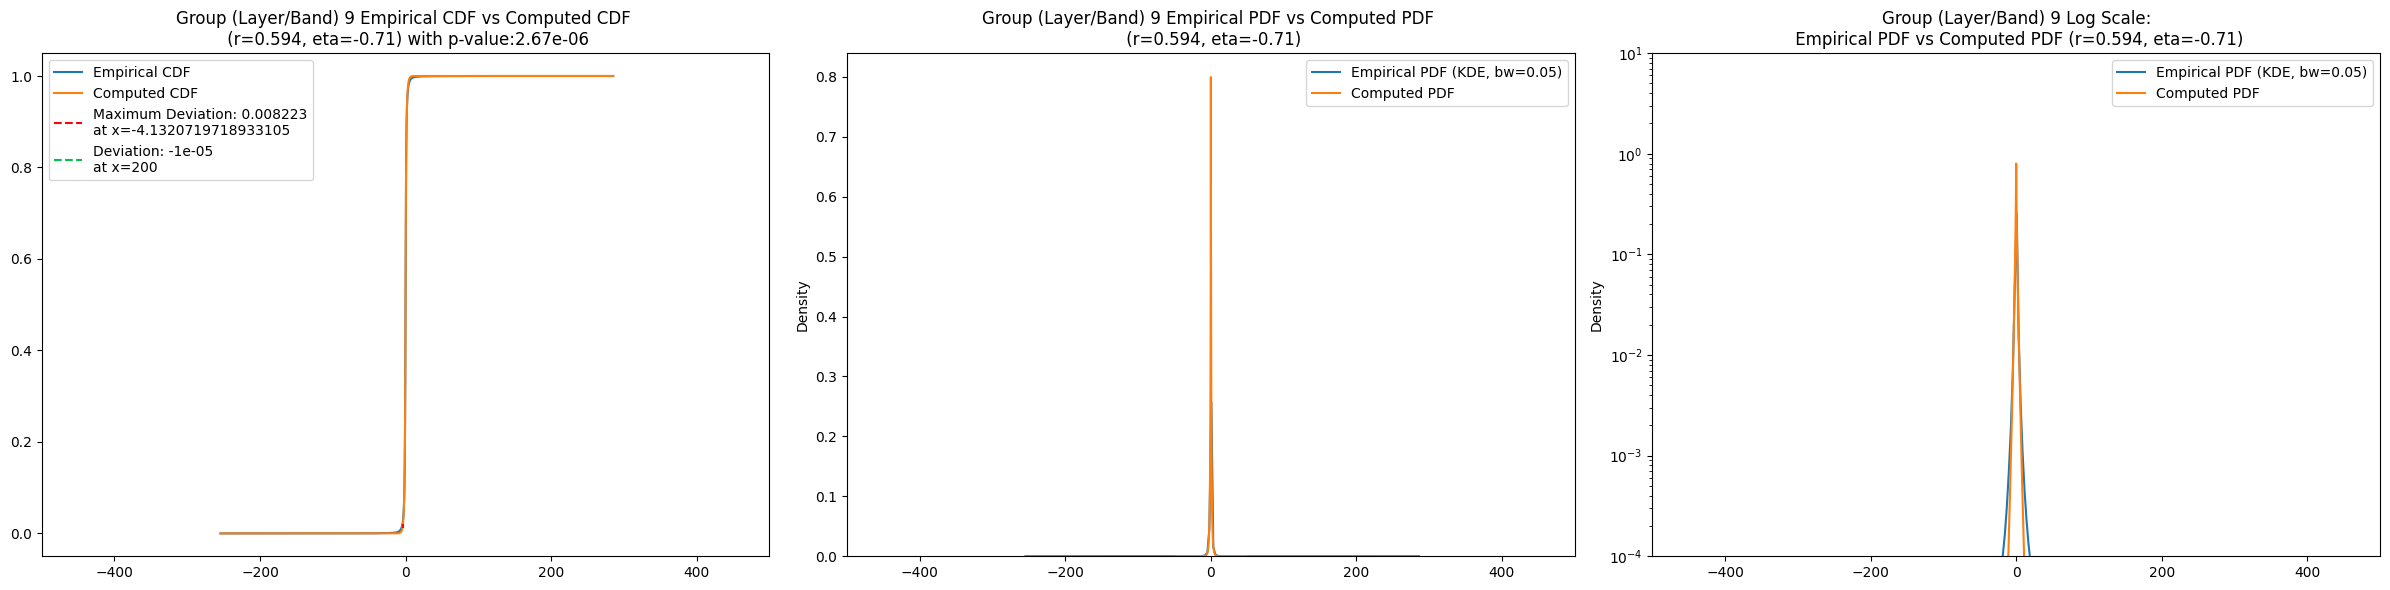

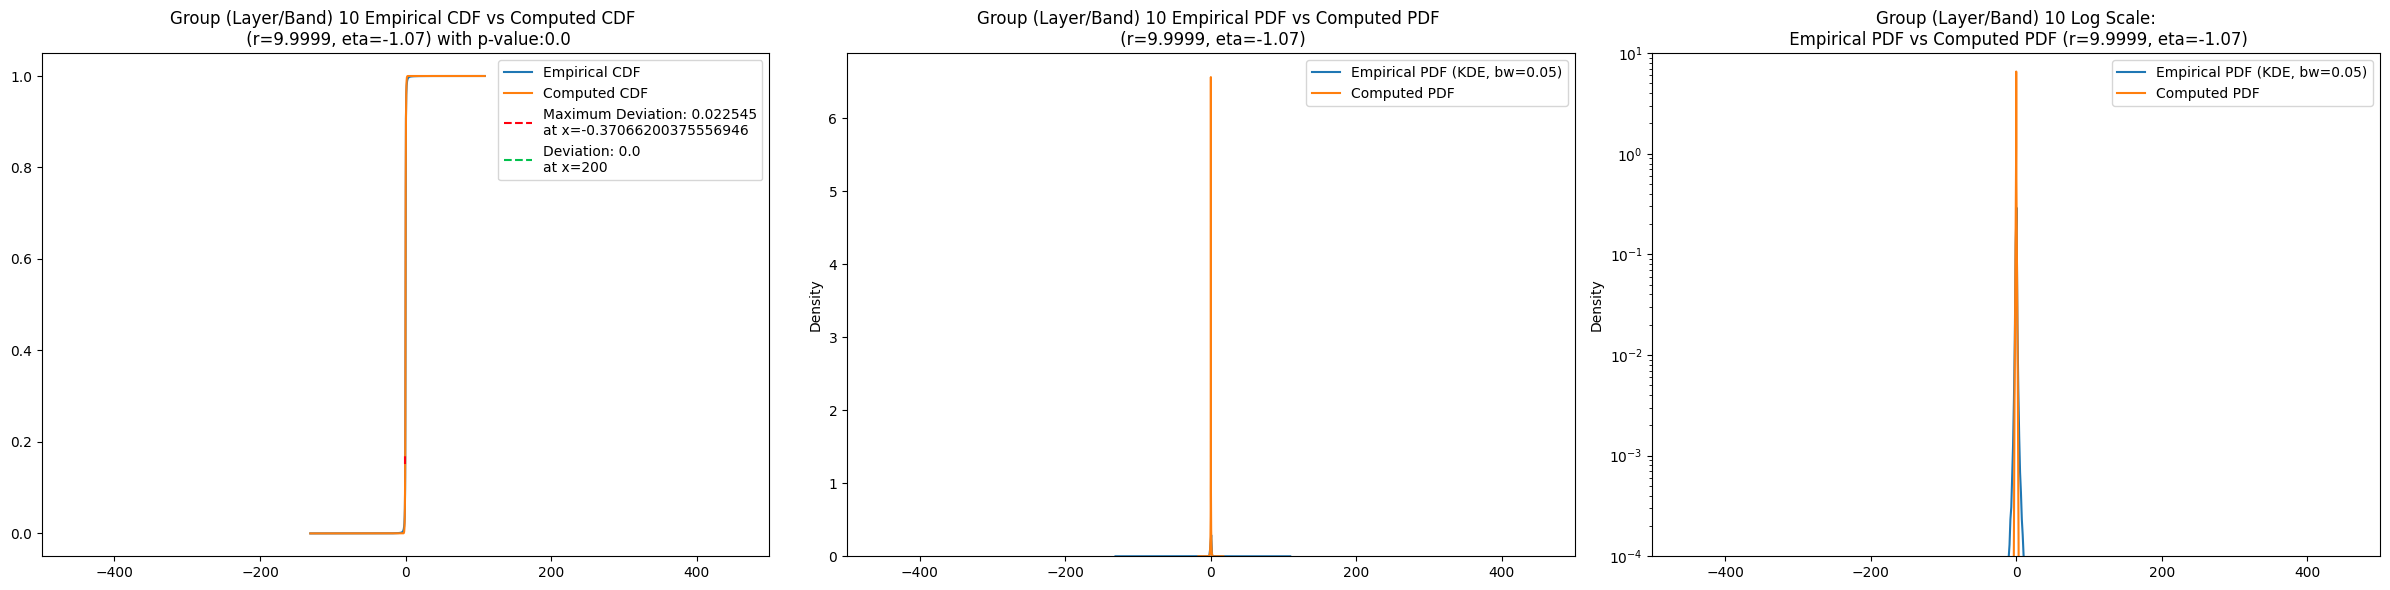

In [13]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta), 
                    log_scale = True,
                    group = group,
                    interval = (-500, 500),
                    provided_loc=200)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [14]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior', 't'")

In [15]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,150199.610000,85008.824102,248364.732266,411.567795,85.166882,581.245881,9000.0,0.22,0.4,0.017328,...,126.386000,0.053287,1.188320e-22,112.080000,0.027644,2.081510e-06,88.349400,0.024432,4.239170e-05,6.077456e-02
3,33515.562000,19958.825879,52689.479258,366.283332,101.325688,561.984535,36000.0,0.22,-0.2,0.015524,...,51.097400,0.057075,2.235480e-102,45.218000,0.030592,1.054640e-29,35.563000,0.028171,2.979370e-25,2.954783e-06
4,8690.716000,4650.655151,15441.937554,584.811266,124.448718,1337.453648,144000.0,0.27,0.0,0.014394,...,21.927100,0.052141,0.000000e+00,19.615600,0.027260,2.143050e-93,15.331800,0.022689,7.963070e-65,1.200534e-20
5,1600.961900,772.053137,3722.834314,1309.721219,95.400870,3193.442929,576000.0,0.31,-0.1,0.012362,...,10.281000,0.046289,0.000000e+00,9.169130,0.022133,1.499790e-245,7.236210,0.015874,1.665910e-126,7.520722e-56
6,339.519200,152.123086,1059.839684,2687.210297,93.111475,4763.505439,2304000.0,0.36,-0.2,0.007668,...,5.464020,0.038784,0.000000e+00,4.855720,0.015043,0.000000e+00,3.837820,0.009457,2.077520e-179,3.833990e-97
7,87.086320,35.836773,371.805410,4823.475991,72.400958,6356.322824,9216000.0,0.44,-0.2,0.006620,...,3.123040,0.035890,0.000000e+00,2.768430,0.011098,0.000000e+00,2.214910,0.009042,0.000000e+00,7.390790e-234
8,29.883560,15.550574,79.512060,1685.915861,80.564132,3720.926795,36864000.0,0.48,-0.4,0.006882,...,2.034520,0.040489,0.000000e+00,1.797250,0.014289,0.000000e+00,1.433200,0.012347,0.000000e+00,0.000000e+00
9,8.940126,4.773328,23.294833,1591.253639,83.608903,3578.031731,147456000.0,0.60,-0.7,0.008517,...,1.019810,0.043489,0.000000e+00,0.905438,0.018283,0.000000e+00,0.715500,0.014077,0.000000e+00,0.000000e+00
10,1.353995,0.687269,4.314199,2561.703720,78.230434,4657.250795,589824000.0,49.00,-1.1,0.027959,...,0.370727,0.044892,0.000000e+00,0.329689,0.020144,0.000000e+00,0.259616,0.015220,0.000000e+00,0.000000e+00


In [16]:
# def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
#     if metric_name == 'kstest_ratio':
#         metric = compute_ksratio
#     elif metric_name == 'kstest_stat':
#         metric = compute_ksstat_tail

#     for tail_cutoff in tail_cutoffs:
#         metrics = []
#         for layer in layers:
#             if distro == 'gengamma':
#                 cdf = all_cdfs[(master_df.loc[layer, 'initial_r'], master_df.loc[layer, 'initial_eta'])]
#             elif distro == 'gaussian':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
#             elif distro == 'laplace':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
#             elif distro == 't':
#                 cdf = scipy.stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
#             metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
#         master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
# for group in GROUPS:
#     add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
#     add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))

# master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))

# master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
# master_df

## Results

In [17]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [18]:
master_df#.filter(regex='total_samples|kstest_stat.*')
#master_df.filter(regex='total_samples|param.*')
# master_df.filter(regex='.*gaussian')
#master_df.filter(regex='kstest_stat_.*[\_(tail\d)]')
#master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,150199.610000,85008.824102,248364.732266,411.567795,85.166882,581.245881,9000.0,0.22,0.4,0.017328,...,126.386000,0.053287,1.188320e-22,112.080000,0.027644,2.081510e-06,88.349400,0.024432,4.239170e-05,6.077456e-02
3,33515.562000,19958.825879,52689.479258,366.283332,101.325688,561.984535,36000.0,0.22,-0.2,0.015524,...,51.097400,0.057075,2.235480e-102,45.218000,0.030592,1.054640e-29,35.563000,0.028171,2.979370e-25,2.954783e-06
4,8690.716000,4650.655151,15441.937554,584.811266,124.448718,1337.453648,144000.0,0.27,0.0,0.014394,...,21.927100,0.052141,0.000000e+00,19.615600,0.027260,2.143050e-93,15.331800,0.022689,7.963070e-65,1.200534e-20
5,1600.961900,772.053137,3722.834314,1309.721219,95.400870,3193.442929,576000.0,0.31,-0.1,0.012362,...,10.281000,0.046289,0.000000e+00,9.169130,0.022133,1.499790e-245,7.236210,0.015874,1.665910e-126,7.520722e-56
6,339.519200,152.123086,1059.839684,2687.210297,93.111475,4763.505439,2304000.0,0.36,-0.2,0.007668,...,5.464020,0.038784,0.000000e+00,4.855720,0.015043,0.000000e+00,3.837820,0.009457,2.077520e-179,3.833990e-97
7,87.086320,35.836773,371.805410,4823.475991,72.400958,6356.322824,9216000.0,0.44,-0.2,0.006620,...,3.123040,0.035890,0.000000e+00,2.768430,0.011098,0.000000e+00,2.214910,0.009042,0.000000e+00,7.390790e-234
8,29.883560,15.550574,79.512060,1685.915861,80.564132,3720.926795,36864000.0,0.48,-0.4,0.006882,...,2.034520,0.040489,0.000000e+00,1.797250,0.014289,0.000000e+00,1.433200,0.012347,0.000000e+00,0.000000e+00
9,8.940126,4.773328,23.294833,1591.253639,83.608903,3578.031731,147456000.0,0.60,-0.7,0.008517,...,1.019810,0.043489,0.000000e+00,0.905438,0.018283,0.000000e+00,0.715500,0.014077,0.000000e+00,0.000000e+00
10,1.353995,0.687269,4.314199,2561.703720,78.230434,4657.250795,589824000.0,49.00,-1.1,0.027959,...,0.370727,0.044892,0.000000e+00,0.329689,0.020144,0.000000e+00,0.259616,0.015220,0.000000e+00,0.000000e+00
